<a href="https://colab.research.google.com/github/shahin1009/ModelOrderReduction/blob/main/Lab_4_Reduced_Basis_Part_2_(solution).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
try:
     import dlroms.fespaces as fe
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     import dlroms.fespaces as fe

# **Lab 4 - Reduced Basis method (Part 2: time-dependent PDEs)**

The Reduced Basis (RB) method has a straightforward adaptation to time-dependent PDEs. Before coming to that, let us recall what an ordinary time-dependent FOM looks like.

# Time-dependent FOMs in a nutshell

Let us consider a dynamical system of the form

$$\begin{equation}\partial_{t}u + A_{\boldsymbol{\mu}}u = f_{\boldsymbol{\mu}}\end{equation},$$

complemented by suitable initial and boundary conditions. Ex: if $A_{\boldsymbol{\mu}}u = -\nabla\cdot(\sigma_{\boldsymbol{\mu}}\nabla u)$, we obtain the heat equation.
</br>
</br>
Fix a Finite Element space $V_{h}\cong\mathbb{R}^{N_{h}}$. In the most simple case, the Galerkin projection of the above equation (converted in weak form), reads

$$\begin{equation}\tag{1}\mathbf{M}\partial_{t}\mathbf{u} + \mathbf{A}_{\boldsymbol{\mu}}\mathbf{u} = \mathbf{M}\mathbf{f}_{\boldsymbol{\mu}}\end{equation}.$$

where:

- $\mathbf{u}$ is the dof-representation of the FE solution

- $\mathbf{f}_{\boldsymbol{\mu}}=[f_{\boldsymbol{\mu}}(x_{1}),\dots,f_{\boldsymbol{\mu}}(x_{N_{h}})]$ is the dof-representation of the source term

- $\mathbf{M}$ is the mass matrix, yielding $\mathbf{v}^{\top}\mathbf{M}\mathbf{w}=\int_{\Omega} vw$
- $\mathbf{A}_{\boldsymbol{\mu}}$ is a suitable matrix arising from $A_{\boldsymbol{\mu}}$, e.g. such that $\mathbf{v}^{\top}\mathbf{A}_{\boldsymbol{\mu}}\mathbf{w}=\int_{\Omega} vA_{\boldsymbol{\mu}}w.$

*Side note: depending on boundary conditions, suitable adjustments may be required: see lecture notes.*
</br>
</br>
The dynamical system in Eq. (1) can be further discretized in time, e.g. via the Backward Euler formula, yielding

$$\begin{equation}\mathbf{M}\left(\frac{\mathbf{u}_{k+1}-\mathbf{u}_{k}}{\Delta t}\right) + \mathbf{A}_{\boldsymbol{\mu}}\mathbf{u}_{k+1} = \mathbf{M}\mathbf{f}_{\boldsymbol{\mu}}\end{equation}.$$

where $\Delta t>0$ is a suitable time-step of choice, and $\mathbf{u}_{k}$ represents the solution at time $t_{k}$, that is, $u_{k}^{i}\approx u(x_i,t_k)$. Then, given an initial condition $\mathbf{u}_{0}\in\mathbb{R}^{N_{h}}$, the **FOM solver consists of iteratively solving the equation below**
</br>
</br>
$$\begin{equation}\tag{2}\left(\mathbf{M}+\Delta t\mathbf{A}_{\boldsymbol{\mu}}\right)\mathbf{u}_{k+1}=\mathbf{M}\mathbf{u}_{k} + \Delta t\mathbf{M}\mathbf{f}_{\boldsymbol{\mu}}\end{equation},$$
</br>
as to produce a full rollout approximation $\mathbf{u}=[\mathbf{u}_{0},\dots,\mathbf{u}_{N_{t}}]^\top \in \mathbb{R}^{N_{t}\times N_{h}}.$

**Example (Heat equation)**

Let $\Omega=(0,3)\times(0,1)$ be a suitable domain representing an object comprised of three materials, as shown below.

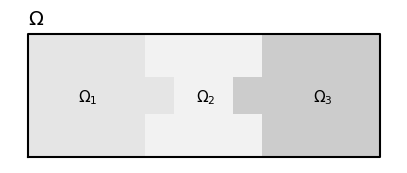

In [7]:
from dlroms.testcases.heatblocks import showdomain
showdomain()

The three materials have heat-conductivity coefficients $\sigma_{i}=10^{\mu_{i}}$. At time $t=0$, the center block is hot (say at 30 °C), while the other two are cold (say at temperature 0 °C). Assuming the system is insulated, the heat propagation can be modeled as
</br></br>
$$\begin{cases}
u(x,0)=\mathbf{1}_{\Omega_{2}}(x)& \text{in}\;\Omega\\\\
\partial_t u - \nabla\cdot(\sigma_{\boldsymbol{\mu}}\nabla u) = 0 & \text{in}\;\Omega\times(0,T)\\\\
\sigma_{\boldsymbol{\mu}}\nabla u\cdot \boldsymbol{n}=0 & \text{in}\;\partial\Omega\times(0,T)
\end{cases}$$
</br>
where $u=u(x,t)$ is the temperature at point $x\in\Omega$ and time $t\in[0,T)$, while
$\sigma_{\boldsymbol{\mu}}:=10^{\mu_1}\mathbf{1}_{\Omega_{1}}+10^{\mu_2}\mathbf{1}_{\Omega_{2}}+10^{\mu_3}\mathbf{1}_{\Omega_{3}}.$

In [8]:
from dlroms.testcases.heatblocks import Vh, FOMsolver

mu = np.array([1, 0.5, -1])
u = FOMsolver(mu, steps = 50, dt = 0.001)

u.shape

(51, 4033)

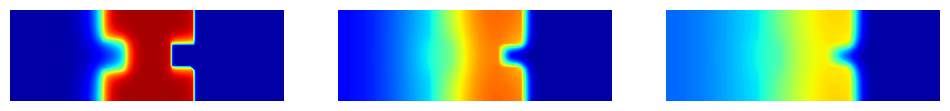

In [9]:
fe.multiplot(u[[1, 25, 50]], (1, 3), Vh, vmin = -1, vmax = 31)

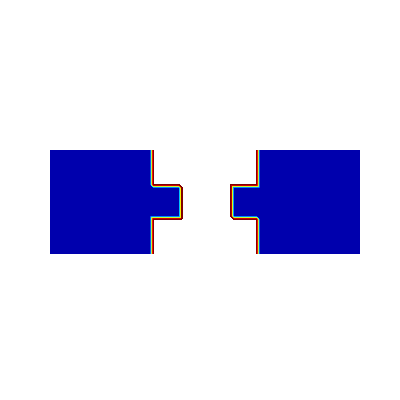

In [10]:
fe.animate(u, Vh)

# Reduced basis approximation

Once again, the idea is to substitute the FOM space $V_h$ with a smaller RB space, $V_{rb}\subset V_h$.

Let $\mathbf{V}\in\mathbb{R}^{N_{h}\times n}$ be an orthogonal matrix, representing a suitable basis of $V_{rb}$, where $\text{dim}(V_{rb})=n$. Projecting the FOM dynamics onto $V_{rb}$ yields the reduced time-evolution scheme below

$$\begin{cases}
\mathbf{c}^{rb}_{0} =\mathbf{V}^{\top}\mathbf{u}_{0} & \\\\
\left(\mathbf{M}^{rb}+\Delta t\mathbf{A}_{\boldsymbol{\mu}}^{rb}\right)\mathbf{c}_{k+1}^{rb}=\mathbf{M}^{rb}\mathbf{c}_{k}^{rb} + \Delta t\mathbf{M}^{rb}\mathbf{f}_{\boldsymbol{\mu}}^{rb}&
\end{cases}$$

where

$$\mathbf{M}^{rb}:= \mathbf{V}^{\top}\mathbf{M}\mathbf{V},\quad\quad \mathbf{A}_{\boldsymbol{\mu}}^{rb}:= \mathbf{V}^{\top}\mathbf{A}_{\boldsymbol{\mu}}\mathbf{V},\quad\quad \mathbf{f}^{rb}_{\boldsymbol{\mu}}:=\mathbf{V}^{\top}\mathbf{f}_{\boldsymbol{\mu}}.$$
</br>
</br>
Then, at any time-step, the solution can be lifted at FOM level via $\mathbf{u}^{rb}_{\boldsymbol{\mu},k} := \mathbf{V}\mathbf{c}^{rb}_{\boldsymbol{\mu},k}\approx \mathbf{u}_{\boldsymbol{\mu},k}$.

Once again, any RB implementation must address the following questions:
</br>
</br>
**Q1: Choice of the RB space**

The RB space $V_{rb}$ must be a "good" space for all parameter values and **all time steps**, since the evolution starts and stays within $V_{rb}$. Therefore, an effective approach can be to sample some (random) trajectories and compute a global POD: the training data will consist of all the snapshots in all the training trajectories.
</br>
</br>
**Q2: Assembling the reduced system efficiently**

In general, depending on the problem at hand, this may require some extra effort (see, e.g., hyper-reduction strategies). However, if the system features affine dependencies (cf. Lab 3), we can leverage this structure and pre-assemble most of the operators.

# Numerical exploration

In order to save up some precious time, we have already collected a bunch of random FOM simulations, which we provide below.

In [11]:
from dlroms.testcases.heatblocks import loadData

mu, u = loadData()

<mark>**Exercise 1**</mark></br>
Explore the data provided.

1. What is the FOM dimension? How many trajectories have been simulated? What is the length (in terms of time-steps) of each trajectory?

2. Extract the first $N_{\text{train}}=50$ trajectories and list them in a snapshot matrix $\mathbf{U}_{\text{train}}\in\mathbb{R}^{N_h\times 50N_t}$.

3. By looking at the singular values of $\mathbf{U}_{\text{train}}$, choose a suitable RB dimension and construct the corresponding POD matrix $\mathbf{V}$.

4. Let $\mathbf{u}^{\text{test}}_{j,k}$ be the $j$th simulation in the test set at time $t_k$. Compute the average uniform relative projection error:</br></br>
$$E_{\text{proj}}=\frac{1}{N_{\text{test}}}\sum_{j=1}^{N_{\text{test}}}\left(\max_{k=0,\dots,N_t}\;\frac{\|\mathbf{u}_{j,k}^{\text{test}}-\mathbf{V}\mathbf{V}^\top\mathbf{u}_{j,k}^{\text{test}}\|}{\|\mathbf{u}_{j,k}^{\text{test}}\|}\right)$$
where $\|\cdot\|$ is the Euclidean norm.

In [12]:
mu.shape, u.shape

((100, 3), (100, 51, 4033))

In [13]:
print("FOM dimension: %d." % u.shape[-1])
print("Number of trajectories: %d." % mu.shape[0])
print("Number of time-steps per trajectory: %d." % u.shape[1])

FOM dimension: 4033.
Number of trajectories: 100.
Number of time-steps per trajectory: 51.


In [14]:
ntrain = 50
Utrain = u[:ntrain].reshape(-1, Vh.dim()).T

In [15]:
from scipy.linalg import svd
X, s, Yt = svd(Utrain, full_matrices = False)

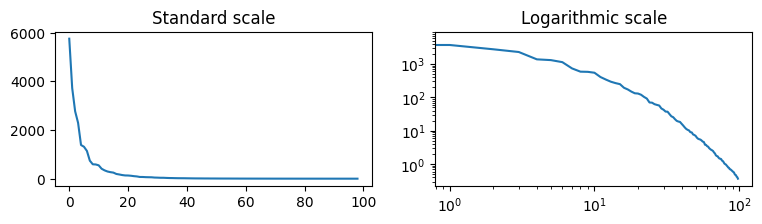

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize = (9, 2))
plt.subplot(1,2,1)
plt.plot(s[1:100])
plt.title("Standard scale")
plt.subplot(1,2,2)
plt.loglog(s[1:100])
plt.title("Logarithmic scale")
plt.show()

In [17]:
n = 30
V = X[:, :n]

In [18]:
from dlroms import num2p
Utest = u[ntrain:].reshape(-1, Vh.dim()).T
Uproj = V @ (V.T @ Utest)

errors = np.linalg.norm(Utest - Uproj, axis = 0) / np.linalg.norm(Utest, axis = 0)

ntest = u.shape[0] - ntrain
errors = errors.reshape(ntest, u.shape[1])

print("Average projection error: %s." % num2p(errors.max(axis = 1).mean()))

Average projection error: 0.77%.


<mark>**Exercise 2**</mark></br>
Construct the RB solver. To this end, notice that $\mathbf{A}_{\boldsymbol{\mu}}=\sum_{i=1}^{p}10^{\mu_i}\mathbf{A}_{i}$, where $p=3$, for suitable matrices $\mathbf{A}_{i}$. The latter, together with the mass matrix $\mathbf{M}$, can be imported from the $\texttt{heat.py}$ module. Since $\mathbf{f}_{\boldsymbol{\mu}}\equiv0$, the source term can be ignored.
</br></br>
1. Pre-compute the reduced matrices $\mathbf{M}^{rb}$ and $\mathbf{A}_{i}^{rb}$ for $i=0,\dots,p$, by projecting the FOM operators $\mathbf{M}$ and $\mathbf{A}_{i}$.

2. Create a function called $\texttt{RBstep}$ that, given the reduced solution (POD coefficients) at current time, $c_{k}$, the time-step $\Delta t$ and the vector of parameters $\boldsymbol{\mu}\in\mathbb{R}^{3}$, computes the evolved coefficients $c_{k+1}$.

3. Create a function called $\texttt{RBsolver}$ that, given the vector of parameters $\boldsymbol{\mu}\in\mathbb{R}^{3}$, a time-step $\Delta t$ and a number of time steps $\texttt{steps}$, produces a full rollout simulation, returning the matrix

$$\mathbf{u}^{rb}=[\mathbf{u}^{rb}_0, \dots, \mathbf{u}^{rb}_{N_t-1}]^{\top}\in\mathbb{R}^{N_t\times N_h}.$$

In [19]:
from dlroms.testcases.heatblocks import M, A1, A2, A3
Mrb  = V.T @ M  @ V
A1rb = V.T @ A1 @ V
A2rb = V.T @ A2 @ V
A3rb = V.T @ A3 @ V

In [20]:
def RBstep(cn, dt, mu):
  th1, th2, th3 = 10.0**mu

  Arb = Mrb + dt*th1*A1rb + dt*th2*A2rb + dt*th3*A3rb
  Frb = Mrb @ cn

  return np.linalg.solve(Arb, Frb)

In [21]:
from dlroms.testcases.heatblocks import u0

def RBsolver(mu, dt = 0.001, steps = 50):

  # Time loop at reduced level
  c0 = V.T @ u0
  c = [c0]
  for n in range(steps):
    c.append(RBstep(c[-1], dt, mu))

  c = np.stack(c) # from list of Nt n-dimensional arrays to a Nt x n array
  u = c @ V.T # lifting to FOM level (c is Nt x n, V is Nh x n, we need u to be Nt x Nh)
  u[0] = u0 # enforcing true value at time 0

  return u

<mark>**Exercise 3**</mark></br>
Evaluate the performances of the RB solver.

1. Compare FOM and ROM solutions for $\boldsymbol{\mu}=[1,-1,0]^\top.$

2. Compute the average uniform relative error over the test set

$$E_{\text{test}}=\frac{1}{N_{\text{test}}}\sum_{j=1}^{N_{\text{test}}}\left(\max_{k=0,\dots,N_t}\;\frac{\|\mathbf{u}_{j,k}^{\text{test}}-\mathbf{u}_{\boldsymbol{\mu}^{\text{test}}_{j}, k}^{rb}\|}{\|\mathbf{u}_{j,k}^{\text{test}}\|}\right)$$

3. **[Extra]** Repeat point (2) using the $L^2$ norm rather than the Euclidean norm.

4. **[Extra]** What is the error trend as a function of time? Compute the relative errors
$$E_{j,k}=\|\mathbf{u}_{j,k}^{\text{test}}-\mathbf{u}_{\boldsymbol{\mu}^{\text{test}}_{j}, k}^{rb}\|/\|\mathbf{u}_{j,k}^{\text{test}}\|$$
and plot the median, the 1st and 3rd quartiles (w.r.t. to $j$) as a function of $k$.

5. Is the RB solver faster than the FOM solver? How much?

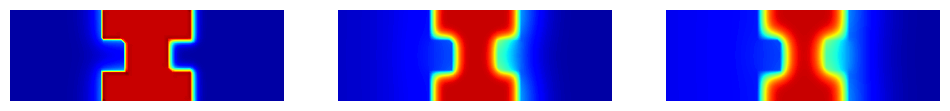

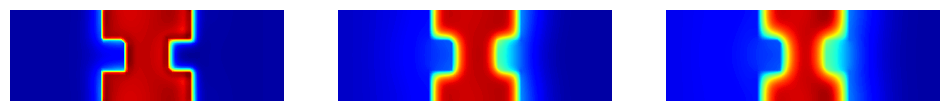

In [22]:
mu0 = np.array([1, -1, 0])
uFOM = FOMsolver(mu0)
uRB = RBsolver(mu0)

fe.multiplot(uFOM[[1, 25, 50]], (1, 3), Vh, vmin = -1, vmax = 32)
fe.multiplot(uRB[[1, 25, 50]],  (1, 3), Vh, vmin = -1, vmax = 32)

In [27]:
uFOM.shape

(51, 4033)

In [28]:
uRB.shape

(51, 4033)

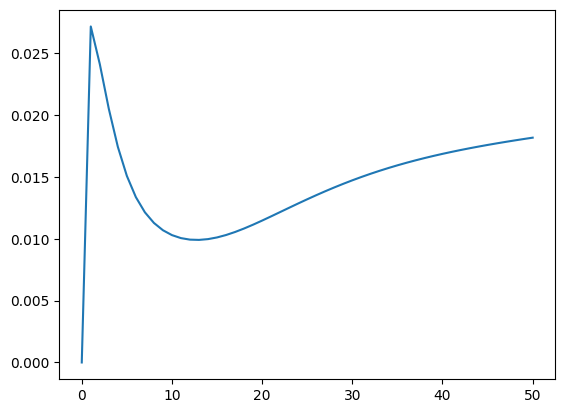

In [32]:
plt.plot(np.linalg.norm(uFOM-uRB, axis = 1)/np.linalg.norm(uFOM, axis = 1))

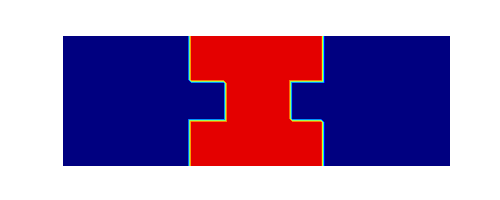

In [ ]:
fe.animate(uFOM, Vh, figsize = (5, 2))

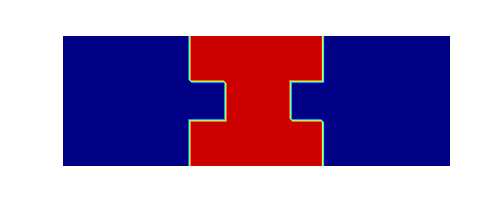

In [ ]:
fe.animate(uRB, Vh, figsize = (5, 2))

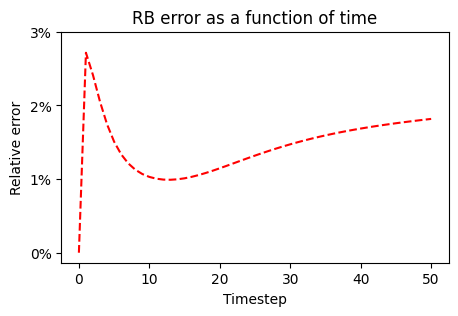

In [ ]:
errors = np.linalg.norm(uFOM-uRB, axis = 1)/np.linalg.norm(uFOM, axis = 1)
plt.figure(figsize = (5, 3))
plt.plot(errors, '--r')
plt.xlabel("Timestep")
plt.ylabel("Relative error")
plt.title("RB error as a function of time")
plt.yticks([0, 0.01, 0.02, 0.03], ["0%", "1%", "2%", "3%"])
plt.show()

In [33]:
utest = u[ntrain:]
uRBtest = [RBsolver(m) for m in mu[ntrain:]]

uRBtest = np.stack(uRBtest)
errors = np.linalg.norm(utest-uRBtest, axis = -1)/np.linalg.norm(utest, axis = -1)
etest = errors.max(axis = -1).mean()

print("Average uniform relative error: %s." % num2p(etest))

Average uniform relative error: 0.93%.


In [38]:
(np.linalg.norm(utest-uRBtest, axis = -1)/np.linalg.norm(utest, axis = -1)).shape

(50, 51)

In [ ]:
l2REs = []
for j in range(len(utest)):
  diff = utest[j] - uRBtest[j]
  l2diff = np.sqrt(np.diag(diff @ M @ diff.T))
  l2norm = np.sqrt(np.diag(utest[j] @ M @ utest[j].T))

  l2REs.append(l2diff/l2norm)

l2REs = np.stack(l2REs)
etestl2 = l2REs.max(axis = -1).mean()

print("Average uniform relative L2 error: %s." % num2p(etestl2))

Average uniform relative L2 error: 0.85%.


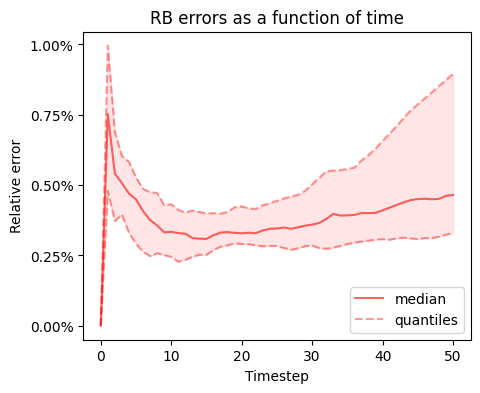

In [ ]:
median = np.quantile(errors, 0.5, axis = 0)
q1 = np.quantile(errors, 0.25, axis = 0)
q3 = np.quantile(errors, 0.75, axis = 0)

plt.figure(figsize = (5, 4))
plt.plot(median, '-r', label = 'median', alpha = 0.6)
plt.plot(q1, '--r', label = 'quantiles', alpha = 0.4)
plt.plot(q3, '--r', alpha = 0.4)
plt.fill_between(np.arange(len(q1)), q1, q3, color = 'red', alpha = 0.1)
plt.xlabel("Timestep")
plt.ylabel("Relative error")
plt.title("RB errors as a function of time")
yticks = np.linspace(0, 0.01, 5)
plt.yticks(yticks, [num2p(tick) for tick in yticks])
plt.legend()
plt.show()

In [ ]:
from time import perf_counter
t0 = perf_counter()
FOMsolver(mu0)
t1 = perf_counter()
dtFOM = t1 - t0
print("FOM evaluation time: %.2f milliseconds." % (1000*dtFOM))

t0 = perf_counter()
RBsolver(mu0)
t1 = perf_counter()
dtROM = t1 - t0
print("ROM evaluation time: %.2f milliseconds." % (1000*dtROM))
print("\n>> Boost: x%d." % (dtFOM//dtROM))

FOM evaluation time: 818.92 milliseconds.
ROM evaluation time: 4.08 milliseconds.

>> Boost: x200.


<mark>**Exercise 4**</mark></br>
Evaluate the performances of the RB solver in the extrapolation regime.

1. Let $\boldsymbol{\mu}=[1,-1,0]^\top.$ Compare FOM and ROM solutions for time instants beyond the time horizon $T=50\Delta t$ (e.g., 200 time steps). Is the RB simulation reliable?

2. Compare FOM and RB solutions for $\boldsymbol{\mu}_{ex}=[-3,4,2]^\top$, that is, for a parameter instance outside of the training range. Is the RB simulation reliable?

3. Let $\boldsymbol{\mu}=[1,-1,0]^\top.$ Let $\Delta t = 1e-5$. Perform 50 time-steps using both the FOM and RB solver. Compare the two solutions: is the RB simulation reliable?

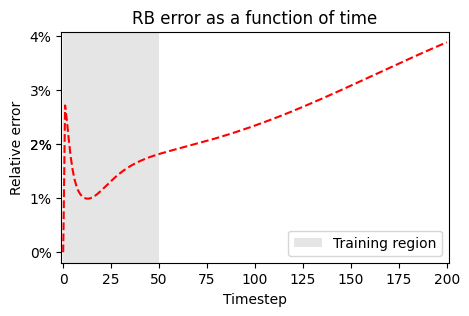

In [ ]:
uFOMex = FOMsolver(mu0, steps = 200)
uRBex = RBsolver(mu0, steps = 200)

errors = np.linalg.norm(uFOMex-uRBex, axis = 1)/np.linalg.norm(uFOMex, axis = 1)
plt.figure(figsize = (5, 3))
plt.plot(errors, '--r')
plt.xlabel("Timestep")
plt.ylabel("Relative error")
plt.title("RB error as a function of time")
marks = np.linspace(errors.min(), errors.max(), 6)
marks = [round(mark, 2) for mark in marks]
plt.yticks(marks, [num2p(mark).replace(".00", "") for mark in marks])
ylim = plt.gca().get_ylim()
plt.fill([0, 50, 50, 0], [ylim[0], ylim[0], ylim[1], ylim[1]], 'k', label = "Training region", alpha = 0.1)
plt.axis([-1, 201, *ylim])
plt.legend()
plt.show()

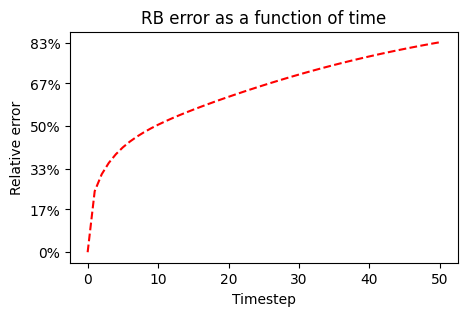

In [ ]:
muex = np.array([-3, 4, 2])
uFOMex = FOMsolver(muex, steps = 50)
uRBex = RBsolver(muex, steps = 50)

errors = np.linalg.norm(uFOMex-uRBex, axis = 1)/np.linalg.norm(uFOMex, axis = 1)
plt.figure(figsize = (5, 3))
plt.plot(errors, '--r')
plt.xlabel("Timestep")
plt.ylabel("Relative error")
plt.title("RB error as a function of time")
marks = np.linspace(errors.min(), errors.max(), 6)
marks = [round(mark, 2) for mark in marks]
plt.yticks(marks, [num2p(mark).replace(".00", "") for mark in marks])
plt.show()

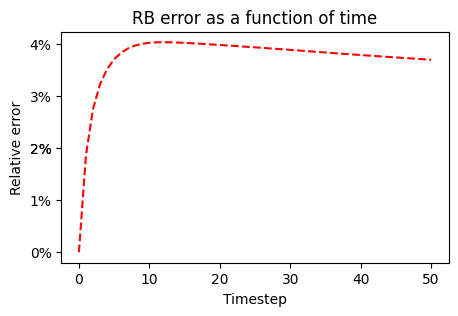

In [ ]:
uFOMex = FOMsolver(mu0, steps = 50, dt = 1e-5)
uRBex = RBsolver(mu0, steps = 50, dt = 1e-5)

errors = np.linalg.norm(uFOMex-uRBex, axis = 1)/np.linalg.norm(uFOMex, axis = 1)
plt.figure(figsize = (5, 3))
plt.plot(errors, '--r')
plt.xlabel("Timestep")
plt.ylabel("Relative error")
plt.title("RB error as a function of time")
marks = np.linspace(errors.min(), errors.max(), 6)
marks = [round(mark, 2) for mark in marks]
plt.yticks(marks, [num2p(mark).replace(".00", "") for mark in marks])
plt.show()